# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/tilapia_UN_tilapia_UN.csv.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/tilapia_DA_tilapia_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,405,Fish (tilapia) - Retail,5,KG,5,2020,138.31
1,405,Fish (tilapia) - Retail,5,KG,5,2020,139.38
2,405,Fish (tilapia) - Retail,5,KG,5,2020,150.00
3,405,Fish (tilapia) - Retail,5,KG,5,2020,128.15
4,405,Fish (tilapia) - Retail,5,KG,5,2020,165.00
...,...,...,...,...,...,...,...
1049,405,Fish (tilapia) - Retail,5,KG,6,2021,113.75
1050,405,Fish (tilapia) - Retail,5,KG,6,2021,150.00
1051,405,Fish (tilapia) - Retail,5,KG,6,2021,142.50
1052,405,Fish (tilapia) - Retail,5,KG,6,2021,146.88


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Fish (tilapia) - Retail,NaN,KG,1,2022,122.97
1,NaN,Fish (tilapia) - Retail,NaN,KG,2,2022,121.40
2,NaN,Fish (tilapia) - Retail,NaN,KG,3,2022,120.10
3,NaN,Fish (tilapia) - Retail,NaN,KG,4,2022,120.05
4,NaN,Fish (tilapia) - Retail,NaN,KG,5,2022,121.83


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,138.31,2020-05-15
1,139.38,2020-05-15
2,150.00,2020-05-15
3,128.15,2020-05-15
4,165.00,2020-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,122.97,2022-01-15
1,121.40,2022-02-15
2,120.10,2022-03-15
3,120.05,2022-04-15
4,121.83,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

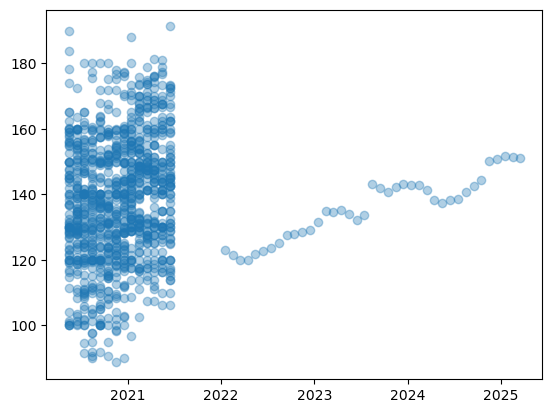

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

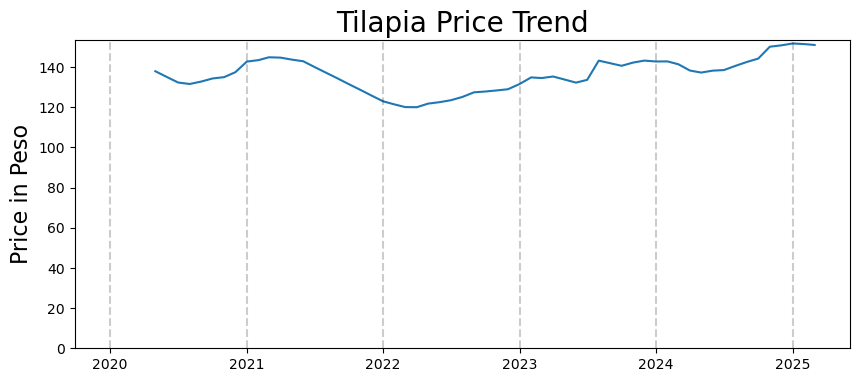

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [21]:
first_diff = lim_tilapia.diff()[1:]

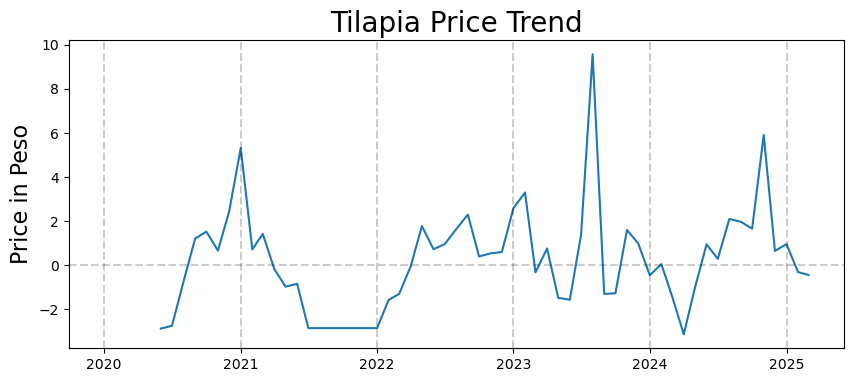

In [22]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [23]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

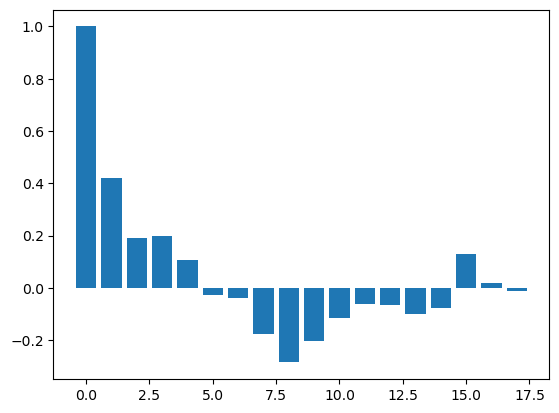

In [24]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

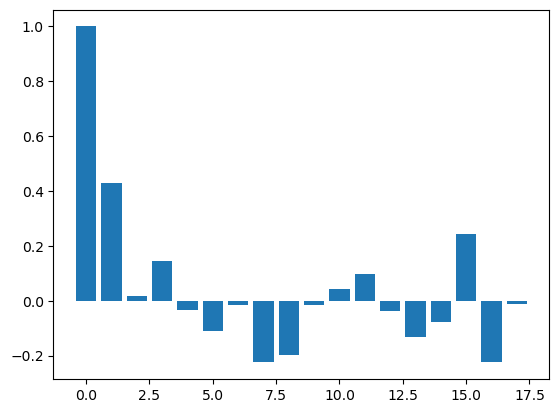

In [25]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [26]:
from datetime import timedelta

In [27]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [28]:
Tilapia.describe()

,mp_price
count,59.000000
mean,136.222861
std,8.371674
min,120.050000
25%,131.556187
50%,137.223956
75%,142.789635
max,151.790000


## Fit the SARIMA Model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [31]:
from time import time

In [32]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24270D+00    |proj g|=  9.57949D-02

At iterate    5    f=  2.20495D+00    |proj g|=  5.25879D-03

At iterate   10    f=  2.20388D+00    |proj g|=  1.48455D-03

At iterate   15    f=  2.20368D+00    |proj g|=  3.72418D-04

At iterate   20    f=  2.20365D+00    |proj g|=  5.91417D-04

At iterate   25    f=  2.20364D+00    |proj g|=  1.62724D-04

At iterate   30    f=  2.20364D+00    |proj g|=  1.07402D-04

At iterate   35    f=  2.20364D+00    |proj g|=  1.61896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [33]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -116.793
Date:                              Mon, 19 May 2025   AIC                            239.586
Time:                                      18:40:16   BIC                            245.440
Sample:                                  05-01-2020   HQIC                           241.830
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7559      1.920      0.394      0.694      -3.006       4.518
ma.S.L12      -0.99

In [34]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    144.27
2024-11-01    150.18
2024-12-01    150.83
2025-01-01    151.79
2025-02-01    151.48


In [35]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [36]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [37]:
predictions

date
2024-10-01    142.933802
2024-11-01    142.871830
2024-12-01    142.737861
2025-01-01    142.304993
2025-02-01    141.968763
2025-03-01    142.248638
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
residuals

date
2024-10-01    1.336198
2024-11-01    7.308170
2024-12-01    8.092139
2025-01-01    9.485007
2025-02-01    9.511237
2025-03-01    8.791362
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

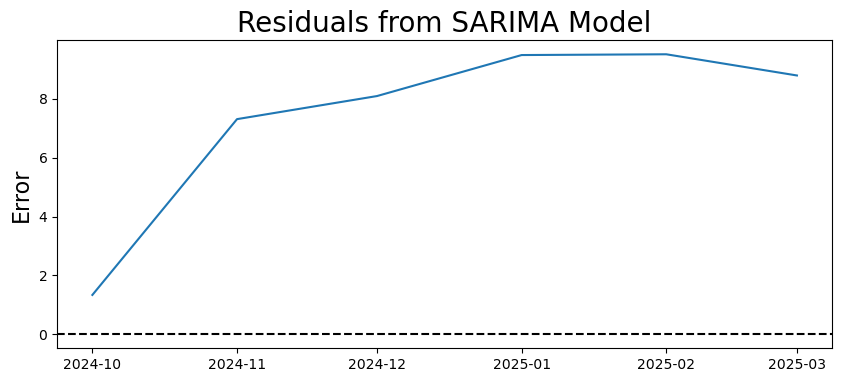

In [39]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

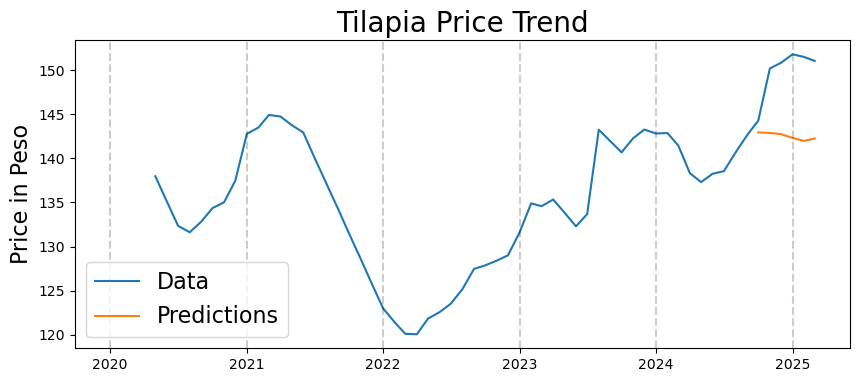

In [40]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [41]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24270D+00    |proj g|=  9.57949D-02

At iterate    5    f=  2.20495D+00    |proj g|=  5.25879D-03

At iterate   10    f=  2.20388D+00    |proj g|=  1.48455D-03

At iterate   15    f=  2.20368D+00    |proj g|=  3.72418D-04

At iterate   20    f=  2.20365D+00    |proj g|=  5.91417D-04

At iterate   25    f=  2.20364D+00    |proj g|=  1.62724D-04

At iterate   30    f=  2.20364D+00    |proj g|=  1.07402D-04

At iterate   35    f=  2.20364D+00    |proj g|=  1.61896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   15    f=  2.19829D+00    |proj g|=  3.85625D-03

At iterate   20    f=  2.19812D+00    |proj g|=  1.22721D-03

At iterate   25    f=  2.19808D+00    |proj g|=  1.20655D-03

At iterate   30    f=  2.19808D+00    |proj g|=  2.61096D-04

At iterate   35    f=  2.19808D+00    |proj g|=  7.84722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     47      1     0     0   1.444D-04   2.198D+00
  F =   2.1980751058252923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32795D+00    |proj g|=  1.98869D-01

At iterate    5    f=  2.25740D+00    |proj g|=  5.41943D-03

At iterate   10    f=  2.25206D+00    |proj g|=  7.42688D-03

At iterate   15    f=  2.25112D+00    |proj g|=  1.42680D-03

At iterate   20    f=  2.25091D+00    |proj g|=  4.90051D-04

At iterate   25    f=  2.25088D+00    |proj g|=  6.57974D-04

At iterate   30    f=  2.25088D+00    |proj g|=  1.91919D-04

At iterate   35    f=  2.25087D+00    |proj g|=  6.34024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30949D+00    |proj g|=  1.72353D-01

At iterate    5    f=  2.24885D+00    |proj g|=  5.75005D-03

At iterate   10    f=  2.24485D+00    |proj g|=  8.20715D-03

At iterate   15    f=  2.24377D+00    |proj g|=  9.08526D-03

At iterate   20    f=  2.24346D+00    |proj g|=  2.39825D-04

At iterate   25    f=  2.24341D+00    |proj g|=  2.28578D-04

At iterate   30    f=  2.24340D+00    |proj g|=  1.66618D-04

At iterate   35    f=  2.24340D+00    |proj g|=  7.91327D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28994D+00    |proj g|=  1.91755D-01

At iterate    5    f=  2.23441D+00    |proj g|=  5.31069D-03

At iterate   10    f=  2.23088D+00    |proj g|=  6.56830D-03

At iterate   15    f=  2.23014D+00    |proj g|=  4.19893D-03

At iterate   20    f=  2.22994D+00    |proj g|=  2.77607D-04

At iterate   25    f=  2.22991D+00    |proj g|=  2.33675D-04

At iterate   30    f=  2.22990D+00    |proj g|=  1.43318D-04

At iterate   35    f=  2.22990D+00    |proj g|=  2.05658D-04

At iterate   40    f=  2.22990D+00    |proj g|=  9.52926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/tmp/ipykernel_150832/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [42]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

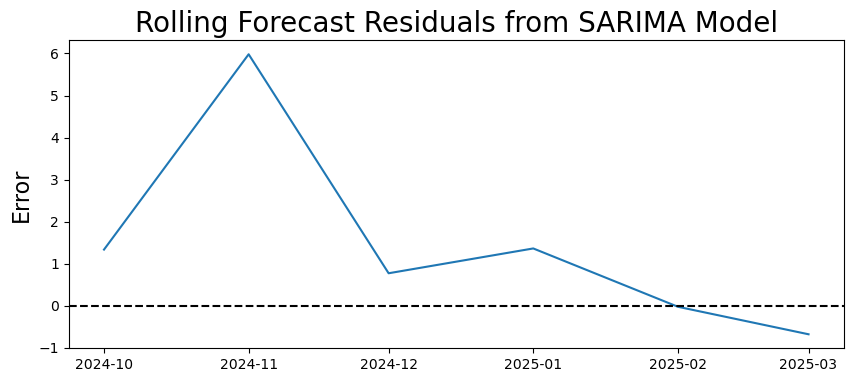

In [43]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

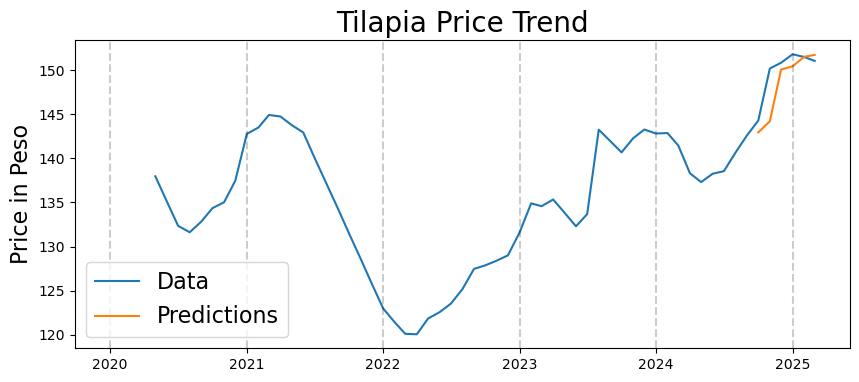

In [44]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [45]:
import numpy as np

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0113


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 2.5970564009683


## Future Predictions (2025)